# MMF1921 (Summer 2025) - Project 1
 
 The purpose of this program is to implement the following factor models
 
     a) Multi-factor OLS regression
     b) Fama-French 3-factor model
     c) LASSO
     d) Best Subset Selection
 
 and to use these factor models to estimate the asset expected returns and covariance matrix. 
 
These parameters will then be used to test the out-of-sample performance using MVO to construct optimal portfolios.
 
 Use can use this template to write your program.

     Student Name:Harry (Junlong) Zhang, Yaxin Lyu
     Student ID: 1006751711, 1006777070

In [1]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from functions.BSS import *
from functions.FF import *
from functions.LASSO import *
from functions.MVO import *
from functions.OLS import *
import pandas as pd

adjClose = pd.read_csv("MMF1921_AssetPrices.csv", index_col=0)
factorRet = pd.read_csv("MMF1921_FactorReturns.csv", index_col=0)

In [2]:
adjClose.index = pd.to_datetime(adjClose.index)
factorRet.index = pd.to_datetime(factorRet.index)

In [3]:
#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF']

In [4]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [5]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]

returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [6]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

In [7]:
factorRet
# rename columns with no spaces
factorRet.columns = factorRet.columns.str.replace(' ', '')



In [8]:
returns

F       CAT       DIS       MCD        KO       PEP  \
Date                                                                     
2006-01-31  0.120718  0.176565  0.052403  0.034756  0.023044 -0.035660   
2006-02-28 -0.074496  0.072889  0.102487 -0.006256  0.010858  0.030353   
2006-03-31 -0.004955 -0.021078 -0.007273 -0.019455  0.001196 -0.021782   
2006-04-30 -0.117922  0.054510 -0.001090  0.002512 -0.001450  0.004187   
2006-05-31  0.025916 -0.041137  0.086544 -0.044798  0.045033  0.033818   
...              ...       ...       ...       ...       ...       ...   
2016-08-31 -0.004939 -0.009987 -0.015729 -0.009530 -0.004784 -0.013214   
2016-09-30 -0.042263  0.083021 -0.017138 -0.002794 -0.017692  0.018723   
2016-10-31 -0.015228 -0.051661 -0.002031 -0.024385  0.001690 -0.014634   
2016-11-30  0.018639  0.144880  0.069271  0.067671 -0.040355 -0.059312   
2016-12-31  0.013914 -0.029810  0.059086  0.020242  0.027209  0.044955   

                 WMT         C       WFC       JPM      AAPL       IBM  \
Date                                                                     
2006-01-31 -0.018244 -0.043681 -0.010981  0.006606  0.046855 -0.014449   
2006-02-28 -0.019665  0.002888  0.034763  0.031569 -0.096368 -0.013995   
2006-03-31  0.041595  0.014846 -0.008840  0.008454 -0.087946  0.024092   
2006-04-30 -0.050382  0.064753  0.071866  0.094983  0.118690 -0.005176   
2006-05-31  0.075497 -0.017313 -0.030615 -0.064679 -0.155174 -0.030421   
...              ...       ...       ...       ...       ...       ...   
2016-08-31 -0.014548  0.089506  0.067255  0.054982  0.023418 -0.002487   
2016-09-30  0.009318 -0.010883 -0.128546 -0.013681  0.065304 -0.000389   
2016-10-31 -0.029318  0.040452  0.038870  0.047392  0.004134 -0.032683   
2016-11-30  0.005755  0.151013  0.159746  0.157422 -0.021647  0.064924   
2016-12-31 -0.011950  0.053610  0.041083  0.076038  0.047655  0.022940   

                 PFE       JNJ       XOM       MRO        ED         T  \
Date                                                                     
2006-01-31  0.097701 -0.046096  0.113644  0.257284  0.011177  0.070249   
2006-02-28  0.025742  0.004236 -0.052251 -0.080411 -0.015327  0.059798   
2006-03-31 -0.052192  0.023533  0.021397  0.075195 -0.055368 -0.023635   
2006-04-30  0.012853 -0.013901  0.032877  0.038280 -0.012336 -0.022110   
2006-05-31 -0.061277  0.029544 -0.033864 -0.053583  0.032254 -0.010023   
...              ...       ...       ...       ...       ...       ...   
2016-08-31 -0.048836 -0.040876 -0.012046  0.104668 -0.052257 -0.055871   
2016-09-30 -0.026924 -0.010339  0.001407  0.052397  0.000464 -0.006805   
2016-10-31 -0.063973 -0.018316 -0.045571 -0.166550  0.003120 -0.083161   
2016-11-30  0.023596 -0.033880  0.056879  0.374747 -0.067709  0.049914   
2016-12-31  0.010279  0.034830  0.033606 -0.041828  0.055741  0.100658   

                  VZ       NEM  
Date                            
2006-01-31  0.061208  0.153803  
2006-02-28  0.061035 -0.147089  
2006-03-31  0.006982 -0.021234  
2006-04-30 -0.022179  0.121087  
2006-05-31 -0.059401 -0.110708  
...              ...       ...  
2016-08-31 -0.055786 -0.131109  
2016-09-30 -0.006888  0.027916  
2016-10-31 -0.064214 -0.057466  
2016-11-30  0.037322 -0.124290  
2016-12-31  0.069439  0.051537  

[132 rows x 20 columns]

# 2. Define your initial parameters

In [9]:
#Initial budget to invest ($100,000)
initialVal = 100000

#Start of in-sample calibration period
calStart = pd.to_datetime('2008-01-01', format = '%Y-%m-%d')
calEnd   = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)

#Start of out-of-sample test period
testStart = pd.to_datetime('2012-01-01', format = '%Y-%m-%d')
testEnd   = testStart + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1)

#Number of investment periods (each investment period is 1 year long)
NoPeriods = 5

#Factor models
#Note: You must populate the functions OLS.py, FF.py, LASSO.py and BSS.py with your own code.
FMList = [OLS, FF, LASSO, BSS]

NoModels = len(FMList)

#Tags for the portfolios under the different factor models
tags = ['OLS portfolio', 'FF portfolio', 'LASSO portfolio', 'BSS portfolio']

## 2.1. Find the optimal K for BSS Model


Restricted license - for non-production use only - expires 2026-11-23
          1         2         3         4         5         6         7  \
0  0.370999  0.438940  0.479656  0.499564  0.505712  0.506151  0.500139   
1  0.338875  0.421346  0.462858  0.481144  0.490257  0.496471  0.493609   
2  0.307754  0.392780  0.440508  0.453038  0.463703  0.462142  0.456508   
3  0.241419  0.361307  0.413111  0.429810  0.433736  0.426110  0.417212   
4  0.305280  0.409791  0.442824  0.466565  0.469068  0.465783  0.459306   

          8  
0  0.491552  
1  0.486034  
2  0.447351  
3  0.408813  
4  0.449604  


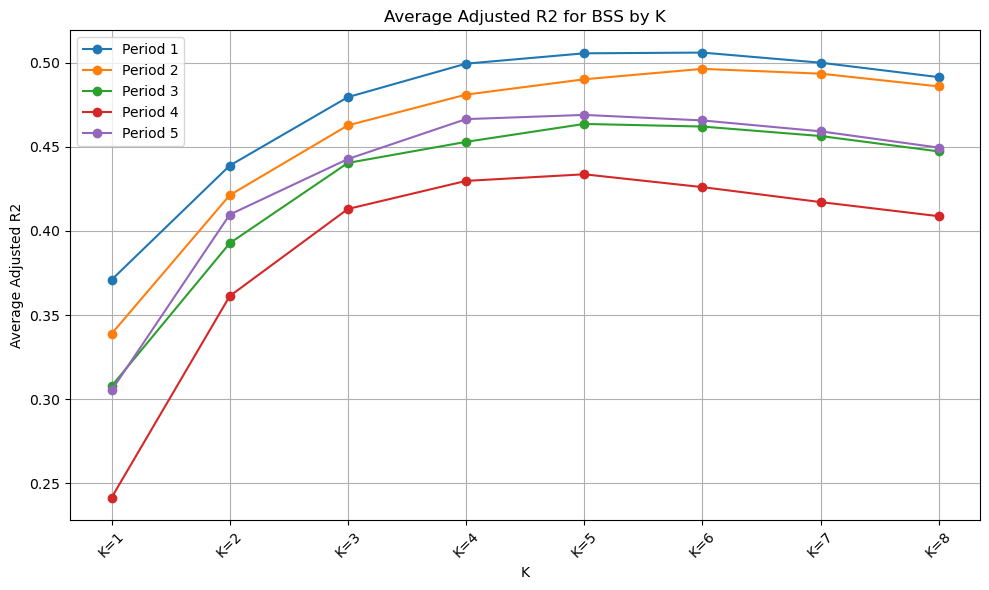

In [10]:
#Initial budget to invest ($100,000)
initialVal = 100000

#Start of in-sample calibration period
calStart = pd.to_datetime('2008-01-01', format = '%Y-%m-%d')
calEnd   = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)

#Start of out-of-sample test period
testStart = pd.to_datetime('2012-01-01', format = '%Y-%m-%d')
testEnd   = testStart + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1)

#Number of investment periods (each investment period is 1 year long)
NoPeriods = 5

#Factor models
#Note: You must populate the functions OLS.py, FF.py, LASSO.py and BSS.py with your own code.
FMList = [OLS, FF, LASSO, BSS]

NoModels = len(FMList)

#Tags for the portfolios under the different factor models
tags = ['OLS portfolio', 'FF portfolio', 'LASSO portfolio', 'BSS portfolio']


Ks = list(range(1, 9))
# DataFrame to hold avg adj-R2: rows = periods, cols = K
avg_adjR2 = pd.DataFrame(index=range(NoPeriods), columns=Ks, dtype=float)

for t in range(NoPeriods):
    # 1) build your in-sample window:
    periodReturns = returns[(calStart <= returns.index) & (returns.index <= calEnd)]
    periodFactRet = factorRet[(calStart <= factorRet.index) & (factorRet.index <= calEnd)]
    lambda_ = 1
    # 2) for each K, fit BSS and record mean(adj_R2)
    for K in Ks:
        _, _, adj_R2 = BSS(periodReturns, periodFactRet, lambda_, K)
        avg_adjR2.at[t, K] = adj_R2.mean()

    # 3) update calStart/calEnd for next period
    calStart = calStart + pd.DateOffset(years=1)
    calEnd   = calStart + pd.DateOffset(years=4) - pd.DateOffset(days=1)

    # print(calStart, calEnd)

# now avg_adjR2 is your matrix: index = period #, columns = K
print(avg_adjR2)

# Make the column be K = 1, 2, ..., 8, rows be period 1, 2, ..., 5

avg_adjR2.columns = [f'K={K}' for K in Ks]
avg_adjR2.index = [f'Period {t+1}' for t in range(NoPeriods)]

# Plot the adj-R2 for each K
plt.figure(figsize=(10, 6))
plt.plot(avg_adjR2.T, marker='o')
plt.title('Average Adjusted R2 for BSS by K')
plt.xlabel('K')
plt.ylabel('Average Adjusted R2')
plt.xticks(rotation=45)
plt.legend(avg_adjR2.index, loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()







### Find the optimal K for each period. 

In [11]:
# find the K that maximizes the average adj-R2 for each period 

K_max = avg_adjR2.idxmax(axis=1)

print(K_max)

# convert into list
K_max = K_max.values.tolist()

# convert into int
K_max = [int(k.split('=')[1]) for k in K_max]

# print the K_max list
print(K_max)

# Now we can use the K_max list to build the portfolios for each period




Period 1    K=6
Period 2    K=6
Period 3    K=5
Period 4    K=5
Period 5    K=5
dtype: object
[6, 6, 5, 5, 5]


## 2.2. Find the Optimal Lambda for the LASSO Model

In [12]:
# define a separate LASSO just for choosing Lambda. 

from sklearn.linear_model import Lasso

def LASSO_Test(returns, factRet, lambda_, K):
    """
    Use this function for the LASSO model. Note that you will not use K
    in this model (K is for BSS).

    Returns:
      mu      : n-vector of expected returns
      Q       : n×n asset covariance matrix
      adj_R2  : n-vector of adjusted R² for each asset regression
    """
    # ----------------------------------------------------------------------
    # Align on dates & drop missing
    data = returns.join(factRet, how='inner').dropna()

    # Factor matrix F (T×8) and compute its mean/covariance
    factor_cols = ['Mkt_RF','SMB','HML','RMW','CMA','Mom','ST_Rev','LT_Rev']
    F = data[factor_cols].values
    T, p = F.shape
    f_mean  = F.mean(axis=0)
    Sigma_f = np.cov(F, rowvar=False, ddof=1)

    assets = returns.columns
    N = len(assets)

    # Storage
    alpha   = np.zeros(N)
    B       = np.zeros((N, p))
    eps_var = np.zeros(N)
    adj_R2  = np.zeros(N)
    p_effs = np.zeros(N)

    # Fit a Lasso for each asset
    for i, asset in enumerate(assets):
        y = data[asset].values
        model = Lasso(alpha=lambda_, fit_intercept=True, max_iter=10000)
        model.fit(F, y)

        alpha[i] = model.intercept_
        B[i, :]  = model.coef_
        resid    = y - model.predict(F)
        eps_var[i] = np.var(resid, ddof=1)

        # Compute R²
        SSR = np.sum(resid**2)
        SST = np.sum((y - y.mean())**2)
        R2  = 1 - SSR / SST

        # count only non-zero factors
        p_eff = np.count_nonzero(model.coef_)
        p_effs[i] = p_eff
        # adjusted R² penalizes only the actually used predictors
        adj_R2[i] = 1 - (1 - R2) * (T - 1) / (T - p_eff - 1)

    # Expected returns
    mu = alpha + B.dot(f_mean)          # (n,)

    # Covariance
    Q  = B.dot(Sigma_f).dot(B.T) + np.diag(eps_var)  # (n, n)
    # ----------------------------------------------------------------------

    return mu, Q, adj_R2, p_effs

### Initialize parameters

In [13]:
#Initial budget to invest ($100,000)
initialVal = 100000

#Start of in-sample calibration period
calStart = pd.to_datetime('2008-01-01', format = '%Y-%m-%d')
calEnd   = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)

#Start of out-of-sample test period
testStart = pd.to_datetime('2012-01-01', format = '%Y-%m-%d')
testEnd   = testStart + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1)

#Number of investment periods (each investment period is 1 year long)
NoPeriods = 5

#Factor models
#Note: You must populate the functions OLS.py, FF.py, LASSO.py and BSS.py with your own code.
FMList = [OLS, FF, LASSO, BSS]

NoModels = len(FMList)

#Tags for the portfolios under the different factor models
tags = ['OLS portfolio', 'FF portfolio', 'LASSO portfolio', 'BSS portfolio']

In [14]:


# your BSS‐unused K placeholder
K = None

# choose your λ‐grid
lambdas = np.logspace(-5, -1, 9)   # e.g. [1e-5, 1e-4.5, …, 1e-1]

# prepare the result matrix
count_within_2_5 = pd.DataFrame(
    index=range(NoPeriods),
    columns=lambdas,
    dtype=int
)

for t in range(NoPeriods):
    # build your in‐sample window
    periodReturns = returns[(calStart <= returns.index) & (returns.index <= calEnd)]
    periodFactRet = factorRet[(calStart <= factorRet.index) & (factorRet.index <= calEnd)]

    for lam in lambdas:
        # call your LASSO function once per period+λ
        _, _, _, nnz = LASSO_Test(periodReturns, periodFactRet, lam, K)

        # count how many assets have between 2 and 5 non-zero betas
        count_within_2_5.at[t, lam] = np.sum((nnz >= 2) & (nnz <= 5))

    # roll your dates forward
    calStart += pd.DateOffset(years=1)
    calEnd   = calStart + pd.DateOffset(years=4) - pd.DateOffset(days=1)

# now count_within_2_5[t, lam] tells you how many assets in period t
# had between 2–5 non‐zero betas under λ=lam

# to pick the “best” λ each period:
best_lambda_per_period = count_within_2_5.idxmax(axis=1)

print(count_within_2_5)
print("Best λ each period:")
print(best_lambda_per_period)


   0.000010  0.000032  0.000100  0.000316  0.001000  0.003162  0.010000  \
0       0.0       1.0      13.0      15.0       4.0       4.0       0.0   
1       0.0       1.0      12.0      13.0       5.0       3.0       0.0   
2       0.0       4.0      18.0      10.0       2.0       0.0       0.0   
3       0.0       5.0      18.0       8.0       2.0       0.0       0.0   
4       1.0       5.0      16.0      12.0       2.0       0.0       0.0   

   0.031623  0.100000  
0       0.0       0.0  
1       0.0       0.0  
2       0.0       0.0  
3       0.0       0.0  
4       0.0       0.0  
Best λ each period:
0    0.000316
1    0.000316
2    0.000100
3    0.000100
4    0.000100
dtype: float64


In [15]:
# save the best lambda for each period in a list
best_lambda = best_lambda_per_period.values.tolist()

best_lambda

[0.00031622776601683794, 0.00031622776601683794, 0.0001, 0.0001, 0.0001]

# 3. Construct and rebalance your portfolios

Here you will estimate your input parameters (exp. returns and cov. matrix etc) from the Fama-French factor models.
You will have to re-estimate your parameters at the start of each rebalance period, and then re-optimize and rebalance your portfolios accordingly.

Ensure you re-initialize the dates above if you run this cell repeatedly. 

 3.1 Initialize

In [16]:
#Initial budget to invest ($100,000)
initialVal = 100000

#Start of in-sample calibration period
calStart = pd.to_datetime('2008-01-01', format = '%Y-%m-%d')
calEnd   = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)

#Start of out-of-sample test period
testStart = pd.to_datetime('2012-01-01', format = '%Y-%m-%d')
testEnd   = testStart + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1)

#Number of investment periods (each investment period is 1 year long)
NoPeriods = 5

#Factor models
#Note: You must populate the functions OLS.py, FF.py, LASSO.py and BSS.py with your own code.
FMList = [OLS, FF, LASSO, BSS]

NoModels = len(FMList)

#Tags for the portfolios under the different factor models
tags = ['OLS portfolio', 'FF portfolio', 'LASSO portfolio', 'BSS portfolio']

In [17]:
# Initiate counter for the number of observations per investment period
toDay = 0

# Preallocate the space for the per period value of the portfolios 
currentVal = {i:np.zeros(NoPeriods) for i in range(NoModels)}

# Number of assets
n  = len(tickers)

# Preallocate space for the portfolio weights
x  = {i:np.zeros([n, NoPeriods]) for i in range(NoModels)}

# Initialize dictionaries to hold Q, mu and the number of shares 
# for each model. These are overwritten at each rebalancing point
mu = {}
Q = {}
NoShares ={}

# Empty lists to measure the value of the portfolio over the period
portfValue = {i:[] for i in range(NoModels)}

#--------------------------------------------------------------------------
# Set the value of lambda and K for the LASSO and BSS models, respectively
# We are using a different lambda\K for each period, so we need to set it up
#--------------------------------------------------------------------------


lambda_list = best_lambda
K_list    = K_max


# storage for average adj-R2
adjR2 = {i: np.zeros(NoPeriods) for i in range(NoModels)}


for t in range(NoPeriods):

    # pull the correct λ and K for this period
    lambda_ = lambda_list[t]
    K = K_list[t]


    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[(calStart <= returns.index)&(returns.index <= calEnd)]
    periodFactRet = factorRet[(calStart <= factorRet.index) &(factorRet.index <= calEnd)]
    # print(periodFactRet.columns)
    current_price_idx = (calEnd - pd.offsets.DateOffset(days = 7) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]
    
    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        for i in range(NoModels):
            currentVal[i][0] = initialVal # all models start with the same amount of $
    else:
        for i in range(NoModels):
            currentVal[i][t] = (currentPrices @  NoShares[i].values.T).squeeze()
    
    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Calculate 'mu' and 'Q' using the 4 factor models.
    # Note: You need to write the code for the 4 factor model functions. 
    for i in range(NoModels):
        
        mu[i], Q[i], adj_R2  = FMList[i](periodReturns, periodFactRet, lambda_, K)
        
        adjR2[i][t] = adj_R2.mean()    
    # Optimize your portfolios to get the weights 'x'
    # Note: You need to write the code for MVO with no short sales
    for i in range(NoModels):
        
        # Define the target return as the geometric mean of the market 
        # factor for the current calibration period
        targetRet = gmean(periodFactRet.iloc[:,0] + 1) - 1 
        
        x[i][:,t] = MVO(mu[i], Q[i], targetRet) 

    # Calculate the optimal number of shares of each stock you should hold
    for i in range(NoModels):
        
        # Number of shares your portfolio holds per stock
        NoShares[i] = x[i][:,t]*currentVal[i][t]/currentPrices
        
        # Weekly portfolio value during the out-of-sample window
        portfValue[i].append(periodPrices @ NoShares[i].values.T)
        

    # Update your calibration and out-of-sample test periods
    calStart = calStart + pd.offsets.DateOffset(years=1)
    calEnd   = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)
    
    testStart = testStart + pd.offsets.DateOffset(years=1)
    testEnd   = testStart + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1)
    
for i in range(NoModels):
    portfValue[i] = pd.concat(portfValue[i], axis = 0)
    
# Overwrite into a dataframe
portfValue = pd.DataFrame([portfValue[i].values.squeeze() for i in range(NoModels)], 
                          index = tags, columns = portfValue[0].index).T


# ------------------------------------------------------------------------
# AFTER the loop: build final DataFrame of average adj-R2
# ------------------------------------------------------------------------
# use your tags or simply model indices as column names
adjR2_df = pd.DataFrame(adjR2, index=[f"Period_{t}" for t in range(NoPeriods)])
adjR2_df.columns = tags 


In [18]:
portfValue

OLS portfolio   FF portfolio  LASSO portfolio  BSS portfolio
Date                                                                    
2012-01-31   98591.215634   98413.389173     98502.522414   98516.829547
2012-02-29   98169.799657   97871.757888     98316.692726   98139.918212
2012-03-31   99661.609418   99187.470881     99547.607055   99446.411306
2012-04-30   99737.827597   99126.722834     99452.709718   99725.372183
2012-05-31  100976.848892  100259.519471     99881.965600  101168.955108
2012-06-30  104702.989533  104200.364786    104202.041252  104921.148343
2012-07-31  108375.995172  107846.839379    107560.380508  108785.177454
2012-08-31  105686.393146  105374.243727    105362.588436  106133.269986
2012-09-30  107136.967389  106628.893350    107167.674953  107627.393612
2012-10-31  106083.424561  105871.431514    106361.521324  106382.834906
2012-11-30  102933.855379  102985.050089    103594.506145  103308.732979
2012-12-31  101717.003649  101678.018548    102034.776253  102083.241492
2013-01-31  106070.952656  105960.076414    106155.260427  106431.749205
2013-02-28  108709.985530  109168.530946    109207.544302  108941.993432
2013-03-31  113859.293257  114089.111067    114377.438998  114183.920331
2013-04-30  115358.528596  116983.642040    117180.624596  115565.562039
2013-05-31  111226.539791  111514.805136    112225.712828  111531.024581
2013-06-30  110680.632753  111911.077955    112505.271991  110947.881819
2013-07-31  113409.538267  114098.267222    114911.674898  113669.440718
2013-08-31  107966.820960  108767.804974    109600.432973  108257.525820
2013-09-30  107821.149155  108558.721504    109450.012292  108161.233109
2013-10-31  111285.300534  112962.986908    113834.546927  111369.351543
2013-11-30  110913.529539  112342.550836    113854.476770  111235.465311
2013-12-31  110778.966376  112189.898448    113641.271489  111037.130922
2014-01-31  107102.809191  108097.404875    109558.754557  106200.299908
2014-02-28  110812.395948  111058.330579    112503.220114  108971.120936
2014-03-31  112488.461572  112486.566108    113970.780114  110822.154151
2014-04-30  116554.376020  116763.796511    118174.768675  116032.286726
2014-05-31  116970.027030  117728.134410    118908.635371  116607.782798
2014-06-30  118416.666352  119151.334010    120322.120961  118430.587094
2014-07-31  114947.374459  115989.218020    117221.666636  115177.740329
2014-08-31  118184.448433  119343.780885    120592.557971  118756.881115
2014-09-30  118354.661475  119714.521024    121093.866262  118186.322609
2014-10-31  121543.979339  123211.528935    124539.760501  120881.210099
2014-11-30  126440.422567  128632.300640    130160.201111  126080.621783
2014-12-31  123997.380779  125695.294315    126820.704709  122987.593358
2015-01-31  123265.333546  125118.132735    126128.518615  121972.106951
2015-02-28  127528.060192  129483.629874    130803.883483  126214.868760
2015-03-31  124893.512202  126878.443093    128025.268991  123831.184091
2015-04-30  126093.214984  127533.439591    128784.423827  125002.302952
2015-05-31  127415.148346  128466.109608    129733.357424  126394.615525
2015-06-30  123836.914046  124620.078881    125968.000652  122897.577870
2015-07-31  128333.468901  129776.297860    130659.373697  127752.809707
2015-08-31  122794.451738  123675.950322    124695.636424  122270.400651
2015-09-30  122846.931083  123892.960246    124762.365551  122445.527440
2015-10-31  130144.067374  130372.977271    131629.482236  129790.541317
2015-11-30  129629.855217  129173.737677    130727.101761  129320.078179
2015-12-31  130679.258638  130768.770045    132147.988259  130349.878907
2016-01-31  130077.791117  131022.089086    132862.793206  129943.241595
2016-02-29  127965.103261  129427.769422    131701.328326  127488.644761
2016-03-31  134860.688854  136241.223212    138610.285063  133944.230949
2016-04-30  135694.856248  136884.701774    139263.689776  134719.475727
2016-05-31  136723.788014  137800.476593    139909.729477  136172.0618

# 4. Results

In [19]:
#--------------------------------------------------------------------------
# 4.1 Evaluate any measures of fit of the regression models to assess their
# in-sample quality. You may want to modify Section 3 of this program to
# calculate the quality of fit each time the models are recalibrated.
#--------------------------------------------------------------------------
print("Average adjusted R2 (across asset) for each model:")

# make adjR2_df columns be the model name
# make the rows be the period # (1, 2, 3, 4, 5)
adjR2_df.columns = tags
adjR2_df.index = [f'Period {t+1}' for t in range(NoPeriods)]
print(adjR2_df)

#--------------------------------------------------------------------------
# 4.2 Calculate the portfolio average return, variance (or standard 
# deviation), and any other performance and/or risk metric you wish to 
# include in your report.
#--------------------------------------------------------------------------

print("Portfolio performance metrics:")
port_return = portfValue.pct_change(1).iloc[1:, :]
# 1) geometric mean monthly return per portfolio
gm_monthly = port_return.add(1).agg(lambda x: gmean(x), axis=0) - 1

# 2) annualized return
ann_return = (1 + gm_monthly) ** 12 - 1

# 3) annualized volatility
ann_vol = port_return.std(axis=0) * np.sqrt(12)

# 4) Sharpe ratio (assumes rf=0)
sharpe = ann_return / ann_vol

# 5) Sortino ratio
#    - compute monthly downside dev: sqrt(mean(min(r,0)^2))
downside_monthly = np.sqrt((np.minimum(port_return, 0) ** 2).mean(axis=0))
downside_annual  = downside_monthly * np.sqrt(12)
sortino = ann_return / downside_annual

# assemble into one DataFrame
metrics = pd.DataFrame({
    'Ann Return':  ann_return,
    'Ann Vol':     ann_vol,
    'Sharpe':      sharpe,
    'Sortino':     sortino
})

print(metrics)







Average adjusted R2 (across asset) for each model:
          OLS portfolio  FF portfolio  LASSO portfolio  BSS portfolio
Period 1       0.479690      0.435810         0.433274       0.506151
Period 2       0.476705      0.398409         0.385920       0.496471
Period 3       0.436404      0.347258         0.392984       0.463703
Period 4       0.397364      0.280011         0.357184       0.433736
Period 5       0.439286      0.341069         0.404051       0.469068
Portfolio performance metrics:
                 Ann Return   Ann Vol    Sharpe   Sortino
OLS portfolio      0.084412  0.090943  0.928185  1.643578
FF portfolio       0.084585  0.091130  0.928178  1.618717
LASSO portfolio    0.087818  0.090676  0.968478  1.735065
BSS portfolio      0.083374  0.094156  0.885491  1.549669


<Figure size 640x480 with 0 Axes>

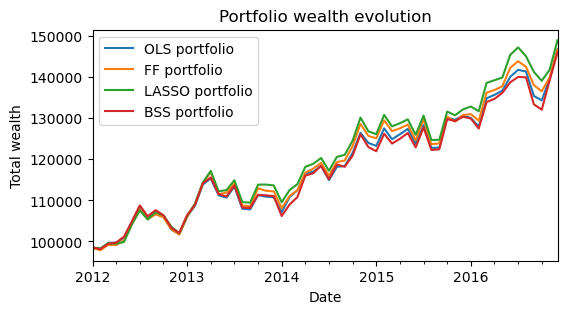

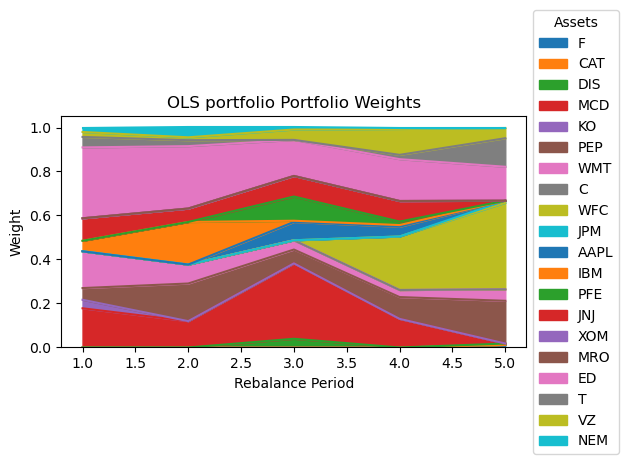

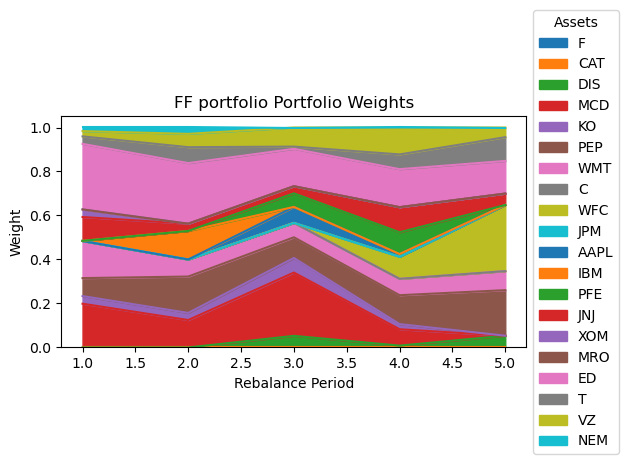

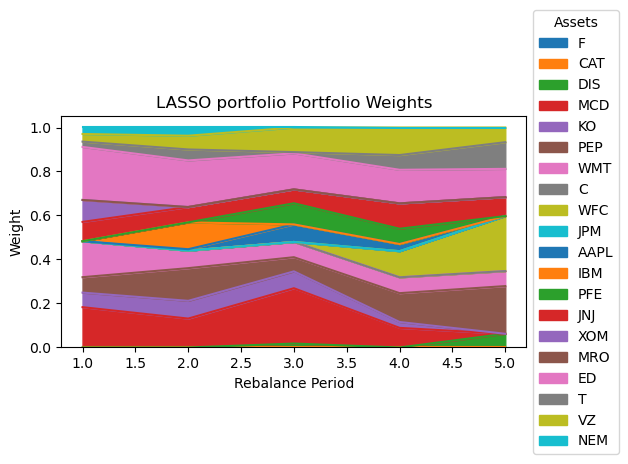

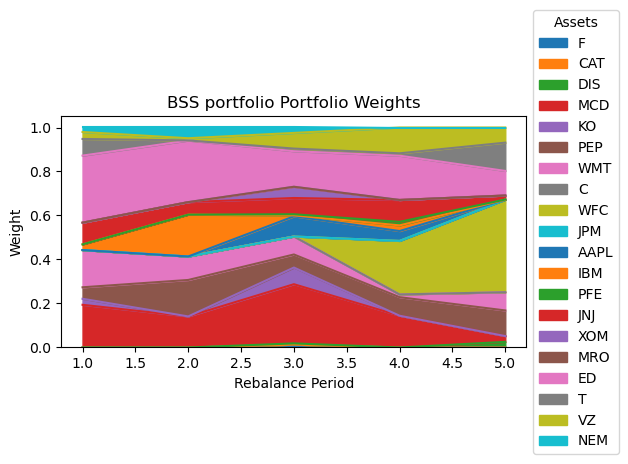

: 

In [ ]:
#--------------------------------------------------------------------------
# 4.3 Plot the portfolio wealth evolution 
# 
# Note: The code below plots all portfolios onto a single plot. However,
# you may want to split this into multiple plots for clarity, or to
# compare a subset of the portfolios. 
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = True)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 4.4 Plot the portfolio weights period-over-period
#--------------------------------------------------------------------------
# OLS Portfolio weights

# fig2 = plt.figure(2)
# x[0][x[0] < 0] = 0
# weights = pd.DataFrame(x[0][(x[0] >0).any(axis=1)], index = tickers[(x[0] >0).any(axis=1)])
# weights.columns = [col + 1 for col in weights.columns]
# weights.T.plot.area(title = 'Portfolio weights',
#                   ylabel = 'Weights', xlabel = 'Rebalance Period',
#                   figsize = (6, 3),
#                   legend = True, stacked = True)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.savefig("images/weights.svg")




for i, tag in enumerate(tags):
    # 1) copy & clip negatives to zero
    W = x[i].copy()
    W[W < 0] = 0

    # 2) drop any assets that are zero in every period
    nonzero = (W > 0).any(axis=1)
    weights = pd.DataFrame(
        W[nonzero],
        index=tickers[nonzero],
        columns=[p+1 for p in range(NoPeriods)]
    )

    # 3) plot
    fig, ax = plt.subplots(figsize=(6, 3))
    weights.T.plot.area(
        ax=ax,
        title=f'{tag} Portfolio Weights',
        xlabel='Rebalance Period',
        ylabel='Weight',
        stacked=True,
        legend=False
    )
    ax.legend(
        loc='center left',
        bbox_to_anchor=(1.0, 0.5),
        title='Assets'
    )

    # 4) save
    safe_tag = tag.replace(' ', '_').lower()
    plt.savefig(f"images/weights_{safe_tag}.svg")
    plt.show()


#
# ###########################################################################
# # Program End